<div class="alert alert-info"><b>Import Libraries<b>

In [2]:
from matplotlib import pyplot as plt
import json
import numpy as np
import random
import datetime
import folium
from math import *
import folium
import altair as alt
import pandas as pd
import pickle
import vincent
from altair_saver import save
from tqdm.notebook import tqdm_notebook
from matplotlib.patches import Rectangle
import datetime
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info"><b>Global Variables<b>

In [3]:
TILES = 'OpenStreetMap'
FILE_NAME = 'gichon.csv'
RESAMPLE = '5min'
NODE = 1012

<div class="alert alert-info"><b>Load node df<b>

In [4]:
def load_point_data(point_id):
    infile = open(f"{point_id}.pkl",'rb')
    df = pickle.load(infile)
    infile.close()
    return(df)

In [7]:
def create_anomaly_df(point_id):
    
    point_df = load_point_data(f'./Data_with_anomalies/{point_id}_data_with_anomalies')
    point_df = point_df[['EC', 'PH', 'ORP', 'TEMPERATURE', 'ALL_DIMS_mp', 
                         'ALL_DIMS_if', 'auto encoder Anomaly', 'ALL_DIMS_eif']]

    point_df = point_df.reset_index()
    point_df.set_index('DateTime', inplace=True)
    point_df = point_df.resample(RESAMPLE).mean()

    point_df[['ALL_DIMS_mp', 'ALL_DIMS_if', 'auto encoder Anomaly', 
                     'ALL_DIMS_eif']] = point_df[['ALL_DIMS_mp', 'ALL_DIMS_if', 
                                                  'auto encoder Anomaly', 'ALL_DIMS_eif']].apply(np.ceil)

    point_df = point_df.replace(0.0, np.nan)

    return point_df

In [8]:
point_df = create_anomaly_df(NODE)

In [9]:
def plot_multi_variant_anomalies(point_df):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(30,8),
                                             gridspec_kw={'hspace': 0}, 
                                             sharex=True)
    fig.suptitle(f'Anomaly Detection', fontsize='40')

    ax1.plot(point_df['EC'], color='deeppink')
    ax1.set_ylabel('EC', fontsize='8')

    ax2.plot(point_df['PH'], color='teal')
    ax2.set_ylabel('PH', fontsize='8')

    ax3.plot(point_df['ORP'], color='navy')
    ax3.set_ylabel('ORP', fontsize='8')

    ax4.plot(point_df['TEMPERATURE'], color='mediumorchid')
    ax4.set_ylabel('TEMPERATURE', fontsize='8')
    ax4.set_xlabel('Date', fontsize='15')

    window_color = {'auto encoder Anomaly':'salmon', 
                    'ALL_DIMS_eif':'lightgreen', 
                    'ALL_DIMS_if':'lightskyblue', 
                    'ALL_DIMS_mp':'gold'}
    
    rect_legend = []
    for model in ['auto encoder Anomaly', 'ALL_DIMS_eif', 'ALL_DIMS_if', 'ALL_DIMS_mp']:    
        indx = point_df.loc[point_df[model] == 1].index
        for i in indx:
            # Create rectangle x coordinates
            startTime = i - datetime.timedelta(minutes = 5*12)
            endTime = startTime + datetime.timedelta(minutes = 5*24)

            # convert to matplotlib date representation
            start = mdates.date2num(startTime)
            end = mdates.date2num(endTime)
            width = end - start

            # Plot rectangle
            rect1 = Rectangle((start, 0), width, 2000, color=window_color[model])
            rect2 = Rectangle((start, 0), width, 15, color=window_color[model])
            rect3 = Rectangle((start, -400), width, 500, color=window_color[model])
            rect4 = Rectangle((start, 0), width, 30, color=window_color[model])

            ax1.add_patch(rect1) 
            ax2.add_patch(rect2)   
            ax3.add_patch(rect3) 
            ax4.add_patch(rect4)
        rect_legend.append(rect1)
            
    plt.legend(rect_legend, ['auto encoder Anomaly', 'ALL_DIMS_eif', 'ALL_DIMS_if', 'ALL_DIMS_mp'],
               bbox_to_anchor=(-0.03, 2))
    plt.tight_layout()
    plt.show()

    # Anomalies plots
    for model in ['auto encoder Anomaly', 'ALL_DIMS_eif', 'ALL_DIMS_if', 'ALL_DIMS_mp']:    
        df = point_df.reset_index()
        indx = df.loc[df[model] == 1].index
        temp = indx[0]
        for i, num in enumerate(indx):
            if indx[i] > temp+12 or i==0:
                
                fig = plt.figure(figsize=(14, 3))
                ax = fig.add_subplot(1, 1, 1)
                ax.plot(point_df['EC'][num-12:num+13], color='deeppink', label='EC')
                ax.plot(point_df['PH'][num-12:num+13], color='teal', label='PH')
                ax.plot(point_df['ORP'][num-12:num+13], color='navy', label='ORP')
                ax.plot(point_df['TEMPERATURE'][num-12:num+13], color='mediumorchid', label='TEMPERATURE')
                
                ax.set_xlabel('Time')
                ax.set_xlabel('Value')
                ax.set_title(f"{model} Anomaly at {df['DateTime'].iloc[num].date()}", fontsize=15);
                ax.patch.set_facecolor(window_color[model])
                ax.patch.set_alpha(0.05)
                ax.legend(bbox_to_anchor=(-0.05, 1))
                plt.show()
                temp = indx[i]
        print('--------------------------------------------------------------------------------------------------------------------------')

<div class="alert alert-info"><b>Plot Anomalies<b>

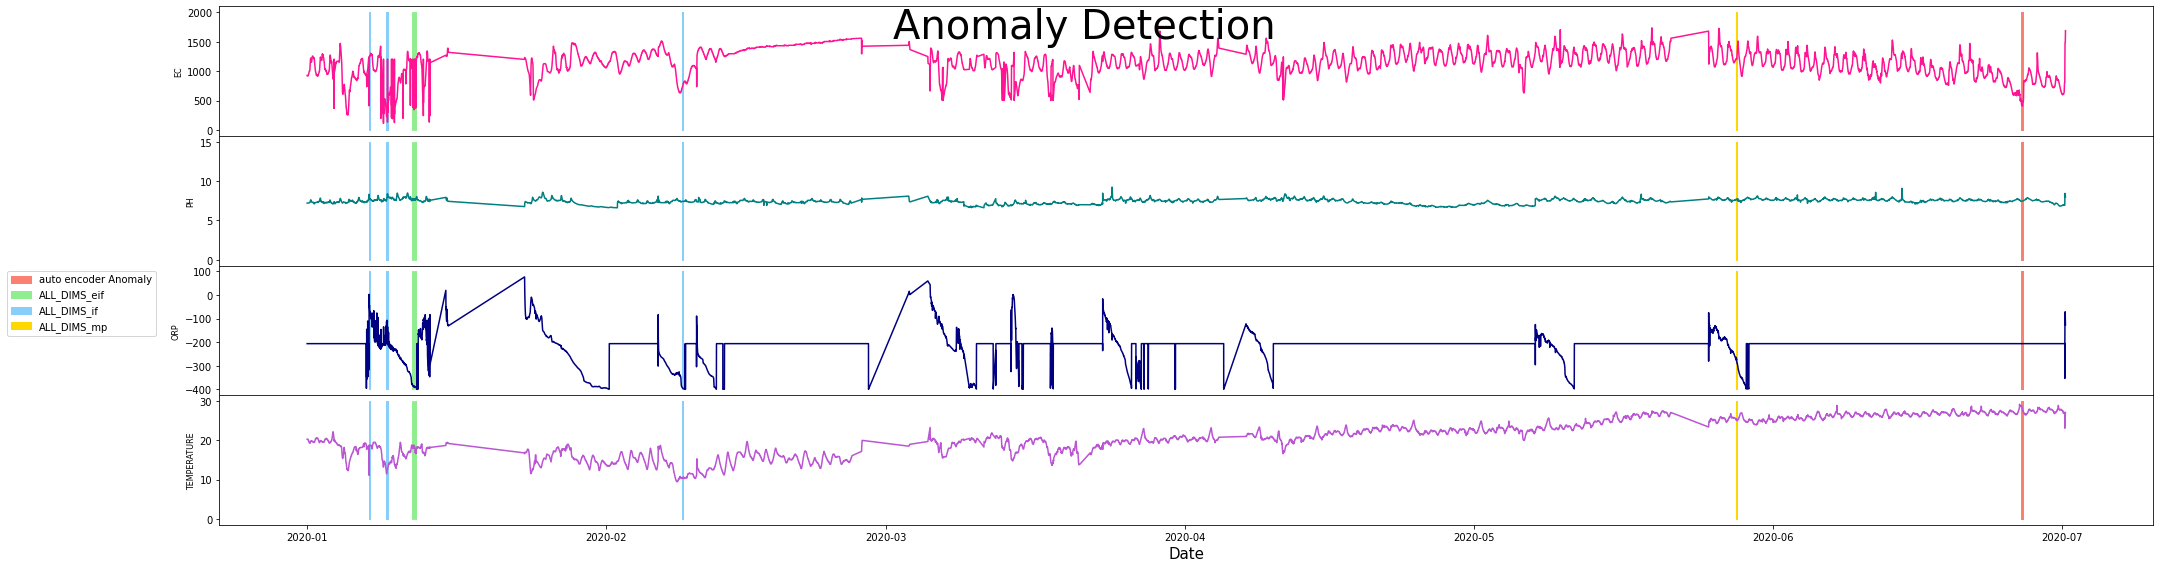

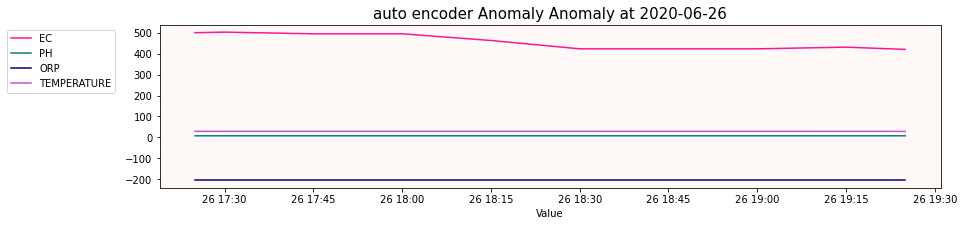

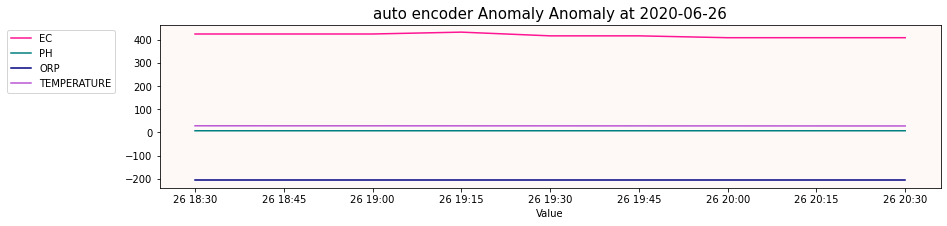

--------------------------------------------------------------------------------------------------------------------------


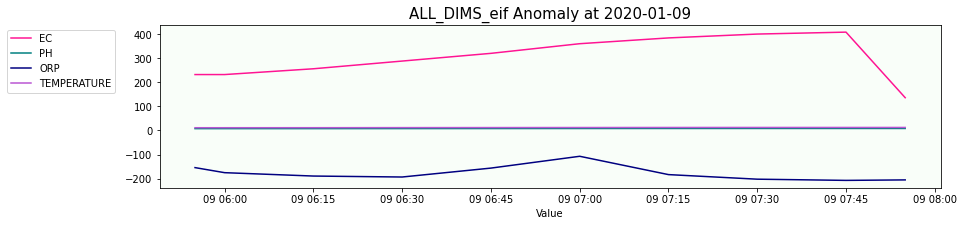

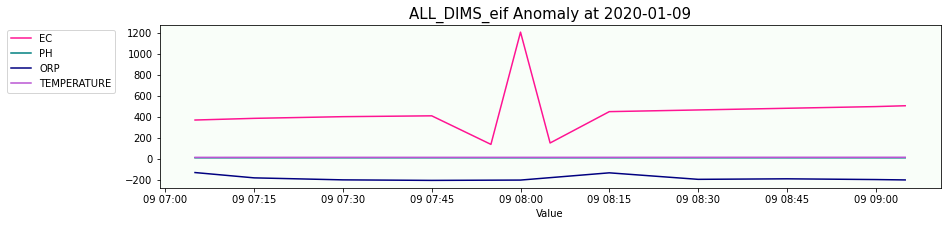

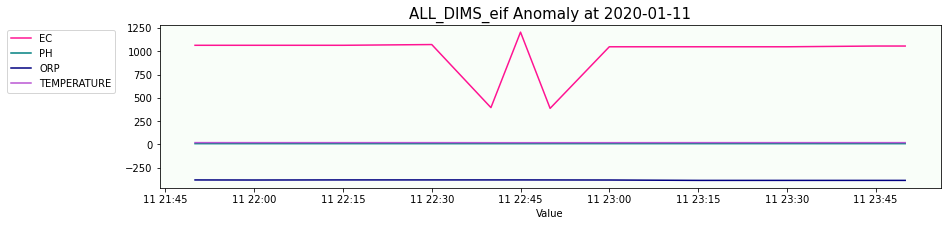

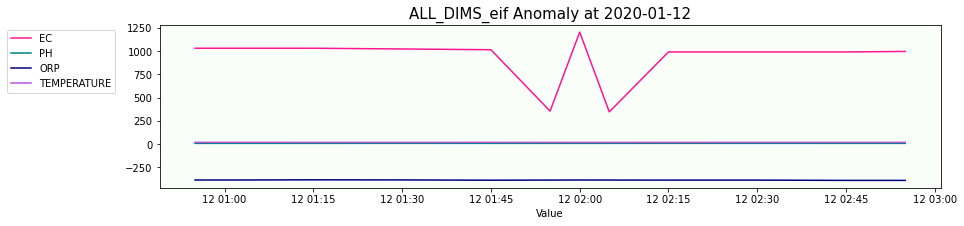

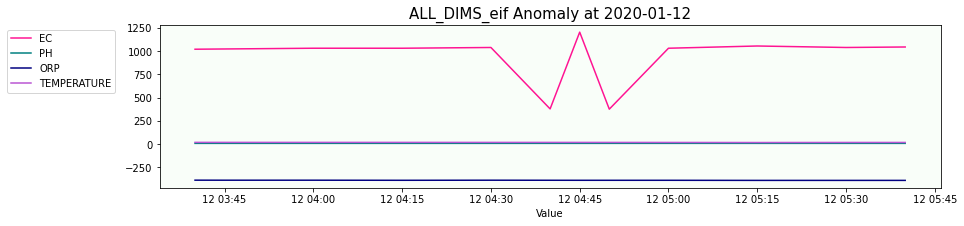

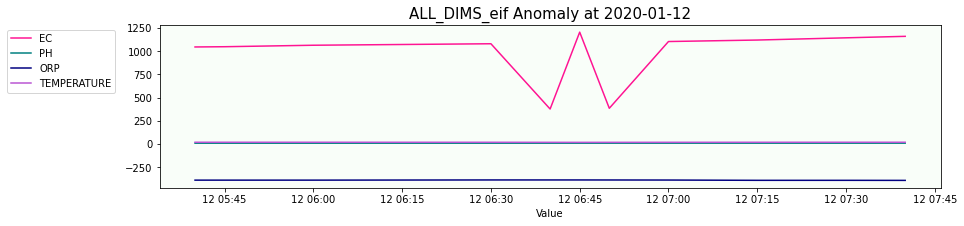

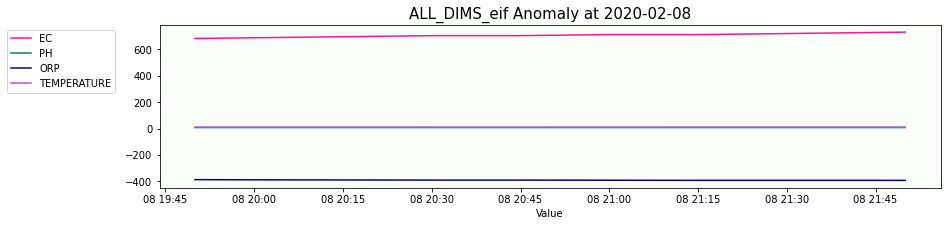

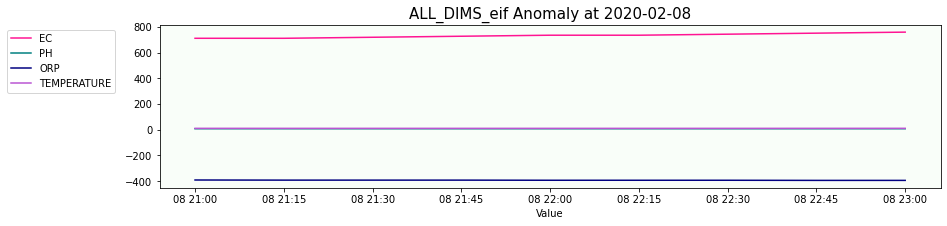

--------------------------------------------------------------------------------------------------------------------------


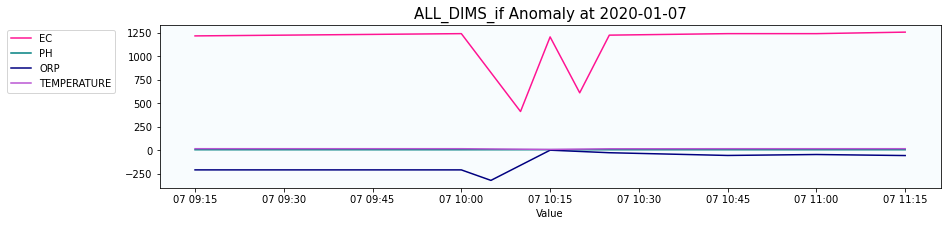

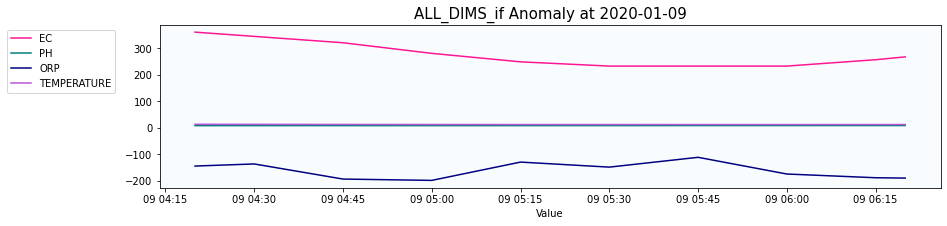

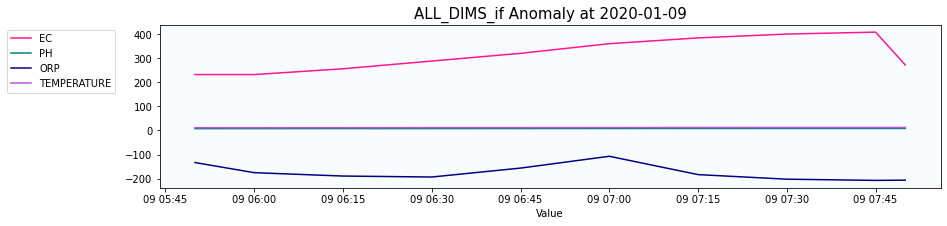

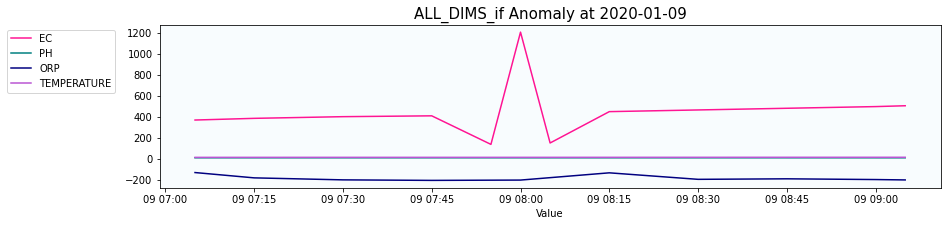

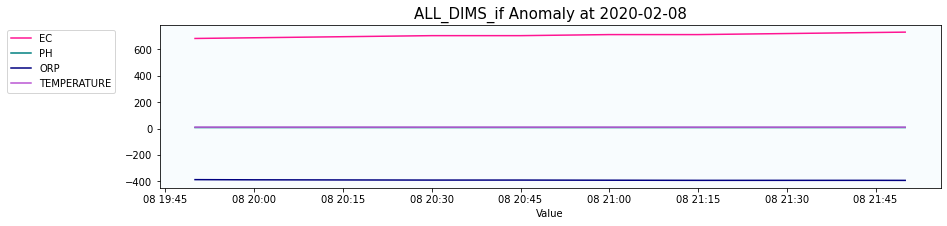

--------------------------------------------------------------------------------------------------------------------------


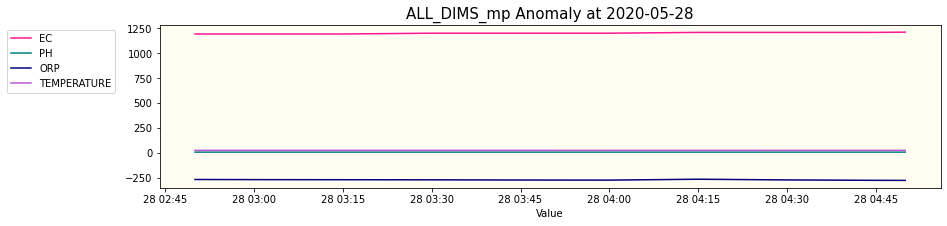

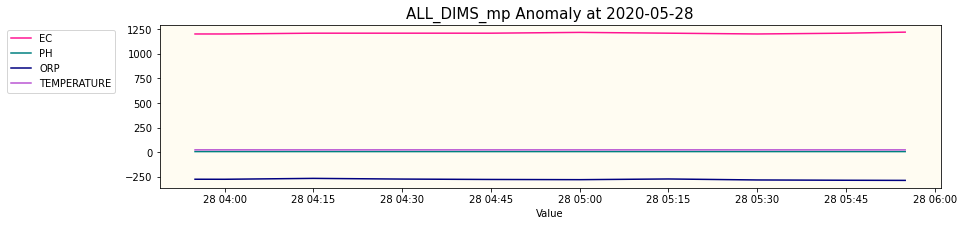

--------------------------------------------------------------------------------------------------------------------------


In [10]:
plot_multi_variant_anomalies(point_df)